Importar as bibliotecas necessárias

In [1]:
import timeit # Para medir o tempo de execução
import optuna # Para otimização de hiperparâmetros
start_time = timeit.default_timer() # Marcar o início do tempo
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np
from torchvision.utils import save_image
import matplotlib.pyplot as plt
# Definir o dispositivo (cuda se disponível, caso contrário CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


O próximo passo é carregar os dados de entrada. Os dados utilizados são valores de momento transversal dos píons e dos káons, partículas filha do méson D0. Inicialmente, os dados se encontram em um .txt, e devem ser transformados em um tensor no PyTorch. Além disso, os dados são normalizados para aumentar a estabilidade do treino e divididos em set de treino, validação e teste.

In [2]:
# Carregar os dados de entrada
#data = np.loadtxt("../Skims/data_D0_daughtersPT_Eta_Phi_trk1_trk2_and_D0PT_Y_Phi_Mass.txt")
data = np.loadtxt("../Skims/data_D0_daughtersPT_Eta_Phi_trk1_trk2_m1_m2_and_D0PT_Y_Phi_Mass.txt")
data = np.transpose(data) # Transposição para obter 1 dim por variável
data = data[(1, 3, 5, 7), :] # Selecionar as variáveis desejadas

# Converter os dados para um tensor PyTorch
tensor_data = torch.tensor(data, dtype=torch.float32)
# Caso nVar > 1, é retransposta
try:
    tensor_data = torch.transpose(tensor_data, 0, 1)
except:
    pass

# Normalização dos dados
mean = tensor_data.mean(dim=0)
std = tensor_data.std(dim=0)
print("Shape do tensor:", tensor_data.shape)
print("Dados Crus:", tensor_data)
tensor_data = (tensor_data - mean) / std
print("Dados normalizados:", tensor_data)
# Necessário para o caso n == 1
try:
    nVar = tensor_data.shape[1] # Dispara uma exceção para tensor unidimensional
    print("Número de variáveis de entrada:", nVar)
except:
    nVar = 1
    print("Número de variáveis de entrada: 1")

# Divisão dos dados em treino, validação e teste
nTotal = tensor_data.size(0)
nTrain = int(0.6 * nTotal)
nVal = int(0.2 * nTotal)
nTest = nTotal - nTrain - nVal
print(f"nTrain: {nTrain}, nVal: {nVal}, nTest: {nTest}")

x_train = tensor_data[:nTrain]
x_val = tensor_data[nTrain:nTrain + nVal]
x_test = tensor_data[nTrain + nVal:]

print(f"x_train: {x_train.size()}, x_val: {x_val.size()}, x_test: {x_test.size()}")

# Configurar DataLoaders para treino, validação e teste
batch_size = 32
trainloader = DataLoader(TensorDataset(x_train), shuffle=True, batch_size=batch_size)
valloader = DataLoader(TensorDataset(x_val), shuffle=False, batch_size=batch_size)
testloader = DataLoader(TensorDataset(x_test), shuffle=False, batch_size=batch_size)

Shape do tensor: torch.Size([92269, 4])
Dados Crus: tensor([[ 2.1387, -0.1102, -3.0579,  0.4937],
        [ 1.7305, -1.0642, -2.6721,  0.1396],
        [ 1.8916, -0.3816,  2.6220,  0.4937],
        ...,
        [ 1.0752,  0.2170, -1.3944,  0.4937],
        [ 1.1270, -0.1384,  1.8298,  0.1396],
        [ 2.4219, -0.1780,  1.4947,  0.1396]])
Dados normalizados: tensor([[ 0.0584,  0.1931, -1.6463,  0.9952],
        [-0.3586, -1.2640, -1.4390, -1.0048],
        [-0.1940, -0.2214,  1.4062,  0.9952],
        ...,
        [-1.0280,  0.6929, -0.7523,  0.9952],
        [-0.9751,  0.1500,  0.9805, -1.0048],
        [ 0.3478,  0.0896,  0.8003, -1.0048]])
Número de variáveis de entrada: 4
nTrain: 55361, nVal: 18453, nTest: 18455
x_train: torch.Size([55361, 4]), x_val: torch.Size([18453, 4]), x_test: torch.Size([18455, 4])


Segue a construção do VAE. Aqui, ele está construído de maneira genérica, sem tamanho das camadas e quantidade de camadas (isso será otimizado posteriormente).

Além disso, definimos a loss function como a divergência KL (diferença entre a distribuição aprendida e a normal padrão) somada ao erro de reconstrução (soma dos  Mean Squared Error (MSE) de X comparado com a reconstrução de X)

In [3]:
class VAE(nn.Module):
    def __init__(self, nVar, h_dims, z_dim, activation):
        super(VAE, self).__init__()
        self.activation = activation

        # Encoder
        encoder_layers = []
        input_dim = nVar
        for h_dim in h_dims:
            encoder_layers.append(nn.Linear(input_dim, h_dim))
            encoder_layers.append(self.activation)
            input_dim = h_dim
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.fc21 = nn.Linear(h_dims[-1], z_dim)
        self.fc22 = nn.Linear(h_dims[-1], z_dim)

        # Decoder
        decoder_layers = []
        input_dim = z_dim
        for h_dim in reversed(h_dims):
            decoder_layers.append(nn.Linear(input_dim, h_dim))
            decoder_layers.append(self.activation)
            input_dim = h_dim
        self.decoder_layers = nn.Sequential(*decoder_layers)
        self.fc3 = nn.Linear(h_dims[0], nVar)

    def encoder(self, x):
        h = self.encoder_layers(x)
        return self.fc21(h), self.fc22(h)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        h = self.decoder_layers(z)
        return self.fc3(h)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

def loss_function(recon_x, x, mu, log_var, beta=0.95):
    BCE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return beta * BCE + (1 - beta) * KLD

Declaração do treinamento do modelo. Ele é feito em epochs, sendo que cada epoch calcula a perda, realiza retropropagação e atualiza os parâmetros do modelo. A perda média de treinamento para a época é então retornada.


Durante o treinamento, a validação é realizada a cada época, e a técnica de early stopping é usada para interromper o treinamento se a perda de validação não melhorar após um número determinado de épocas.

In [4]:
def train(model, trainloader, optimizer):
    model.train()
    train_loss = 0
    for data in trainloader:
        data = data[0].to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss / len(trainloader.dataset)

def validate(model, valloader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            data = data[0].to(device)
            recon_batch, mu, log_var = model(data)
            loss = loss_function(recon_batch, data, mu, log_var)
            val_loss += loss.item()
    return val_loss / len(valloader.dataset)

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        elif self.counter >= self.patience:
            return True
        self.counter += 1
        return False

Em seguida, é definida a função objetivo para a otimização de hiperparâmetros usando Optuna. A função objective sugere valores para os seguintes hiperparâmetros: número de camadas ocultas (n_layers), as dimensões dessas camadas (h_dims), a dimensão do espaço latente (z_dim), a função de ativação (activation_name), o tamanho do batch (batch_size), a taxa de aprendizado (lr) e o otimizador (optimizer_name). Com esses hiperparâmetros, o modelo de VAE é instanciado e configurado. O DataLoader é usado para carregar os dados de treinamento e validação com o tamanho de batch especificado. Dependendo do nome da função de ativação sugerida, a função correspondente é selecionada (ReLU, Tanh ou LeakyReLU). De forma semelhante, o otimizador é configurado de acordo com a sugestão (Adam ou RMSprop).

O modelo é então treinado por um número definido de epochs, durante as quais a função train executa o treinamento e a função validate calcula a perda de validação. O método trial.report é usado para reportar a perda de validação para cada época, e trial.should_prune verifica se a tentativa deve ser interrompida antecipadamente se os resultados não estiverem melhorando, aplicando a técnica de pruning.

In [5]:
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 2, 5)
    h_dims = [trial.suggest_int(f'h_dim_{i}', 32, 256) for i in range(n_layers)]
    z_dim = trial.suggest_int('z_dim', 2, 32)
    activation_name = trial.suggest_categorical('activation', ['relu', 'tanh', 'leaky_relu'])
    batch_size = trial.suggest_int('batch_size', 8, 64)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])


    if activation_name == 'relu':
        activation = nn.ReLU()
    elif activation_name == 'tanh':
        activation = nn.Tanh()
    else:
        activation = nn.LeakyReLU()

    trainloader = DataLoader(TensorDataset(x_train), shuffle=True, batch_size=batch_size)
    valloader = DataLoader(TensorDataset(x_val), shuffle=False, batch_size=batch_size)

    model = VAE(nVar, h_dims, z_dim, activation).to(device)

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)

    early_stopping = EarlyStopping(patience=10, min_delta=0.001)

    for epoch in range(30): #era 30
        train_loss = train(model, trainloader, optimizer)
        val_loss = validate(model, valloader)
        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if early_stopping(val_loss):
            break

    return val_loss

Criar e executar o estudo de otimização de hiperparâmetros. O Optuna realiza a busca pelos melhores hiperparâmetros através de várias tentativas de treinamento. Após completar as tentativas, o melhor trial é recuperado. Os valores e parâmetros desse melhor ensaio são então impressos, mostrando o valor da função objetivo (a perda de validação) e os hiperparâmetros correspondentes que produziram o melhor desempenho do modelo.

Aqui, é inputado o número de trials desejado.

In [6]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:')
trial = study.best_trial
print(' Value: ', trial.value)
print(' Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-08-10 00:02:01,048] A new study created in memory with name: no-name-94d1c7af-07df-4688-894a-f3b50f5b13f6
/tmp/ipykernel_164505/1847795541.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2024-08-10 00:03:44,713] Trial 0 finished with value: 0.39087547664428374 and parameters: {'n_layers': 4, 'h_dim_0': 45, 'h_dim_1': 231, 'h_dim_2': 211, 'h_dim_3': 158, 'z_dim': 7, 'activation': 'relu', 'batch_size': 48, 'lr': 0.0002666839770263148, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.39087547664428374.
[I 2024-08-10 00:10:52,725] Trial 1 finished with value: 0.4051679604254925 and parameters: {'n_layers': 4, 'h_dim_0': 202, 'h_dim_1': 143, 'h_dim_2': 53, 'h_dim_3': 43, 'z_dim': 20, 'activation': 'leaky_relu', 'batch_size': 10, 'lr': 0.0005618015987475652, 'optimi

Best trial:
 Value:  0.38646066502129905
 Params: 
    n_layers: 2
    h_dim_0: 241
    h_dim_1: 140
    z_dim: 3
    activation: tanh
    batch_size: 40
    lr: 4.843031618046735e-05
    optimizer: RMSprop


Os melhores hiperparâmetros encontrados pelo estudo Optuna são recuperados e usados para configurar o modelo VAE. Os melhores parâmetros são extraídos do trial vencedor e utilizados para definir a função de ativação (ReLU, Tanh ou Leaky ReLU), o tamanho do batch e a arquitetura do modelo. O DataLoader é configurado novamente com o melhor tamanho de batch para os dados de treino e validação. Um novo modelo VAE é criado usando os melhores hiperparâmetros. O otimizador apropriado (Adam ou RMSprop) é configurado com a melhor taxa de aprendizado encontrada.

In [7]:
best_params = trial.params
if best_params['activation'] == 'relu':
    activation = nn.ReLU()
elif best_params['activation'] == 'tanh':
    activation = nn.Tanh()
else:
    activation = nn.LeakyReLU()

batch_size = best_params['batch_size']
trainloader = DataLoader(TensorDataset(x_train), shuffle=True, batch_size=batch_size)
valloader = DataLoader(TensorDataset(x_val), shuffle=False, batch_size=batch_size)

model = VAE(nVar, [best_params[f'h_dim_{i}'] for i in range(best_params['n_layers'])], best_params['z_dim'], activation).to(device)

if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=best_params['lr'])

Treinamento final com os melhores hiperparâmetros

In [8]:
# Treinamento final com os melhores hiperparâmetros
early_stopping = EarlyStopping(patience=20, min_delta=0.001)
train_losses, val_losses = [], []
for epoch in range(30):
    train_loss = train(model, trainloader, optimizer)
    val_loss = validate(model, valloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if early_stopping(val_loss):
        break

print('Final Train Loss:', train_loss)
print('Final Validation Loss:', val_loss)

Final Train Loss: 0.3783234607967514
Final Validation Loss: 0.37752356116044156


O modelo é avaliado no conjunto de teste para calcular a perda final de teste

In [9]:
# Teste final
model.eval()
test_loss = 0
with torch.no_grad():
    for data in testloader:
        data = data[0].to(device)
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        test_loss += loss.item()
test_loss /= len(testloader.dataset)
print('Test Loss:', test_loss)

Test Loss: 0.37681177548036704


Abaixo, se iniciam os plots. Primeiramente, temos o erro de reconstrução e KLD sendo minimizados no treinamento

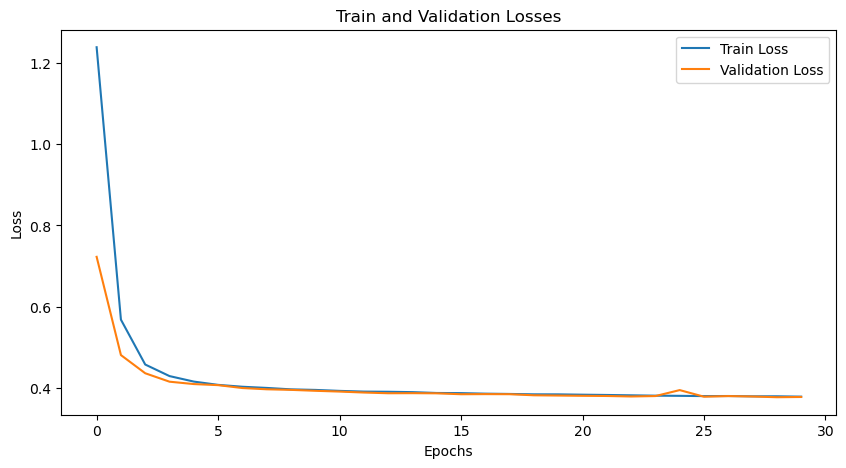

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()

Amostra do VAE tentando reproduzir o dataset de treino (dados normalizados)

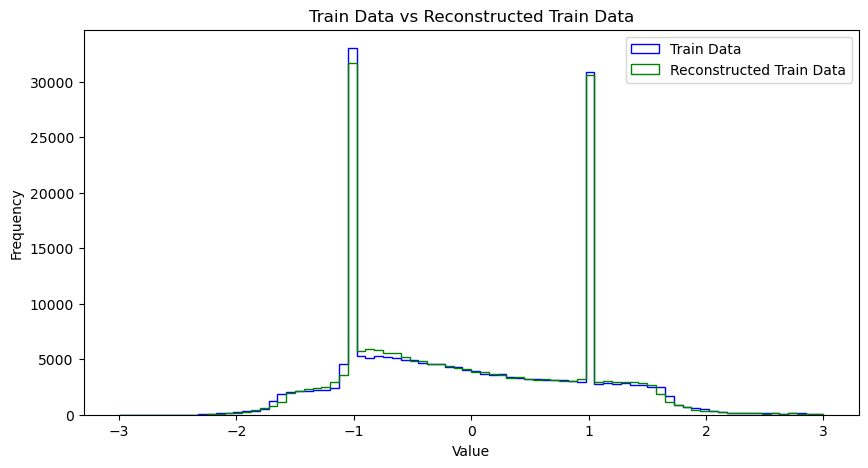

In [11]:
model.eval()
with torch.no_grad():
    recon_train, _, _ = model(x_train.to(device))

plt.figure(figsize=(10, 5))
plt.hist(x_train.cpu().numpy().flatten(), bins=80, range=[-3, 3], histtype='step', color='blue', label='Train Data')
plt.hist(recon_train.cpu().numpy().flatten(), bins=80, range=[-3, 3], histtype='step', color='green', label='Reconstructed Train Data')
plt.title('Train Data vs Reconstructed Train Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Amostra do VAE tentando reproduzir o dataset de teste (dados normalizados)

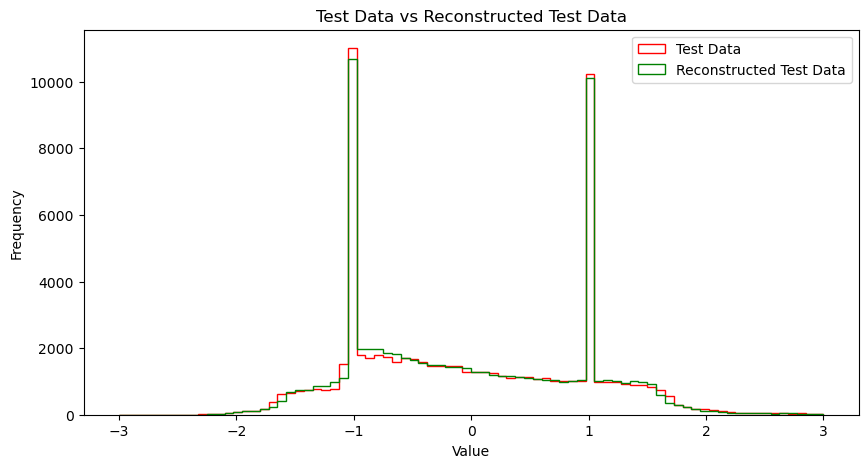

In [12]:
with torch.no_grad():
    recon_test, _, _ = model(x_test.to(device))

plt.figure(figsize=(10, 5))
plt.hist(x_test.cpu().numpy().flatten(), bins=80, range=[-3, 3], histtype='step', color='red', label='Test Data')
plt.hist(recon_test.cpu().numpy().flatten(), bins=80, range=[-3, 3], histtype='step', color='green', label='Reconstructed Test Data')
plt.title('Test Data vs Reconstructed Test Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Amostra do VAE tentando gerar novos dados que seguem a distribuição do input (dados normalizados)

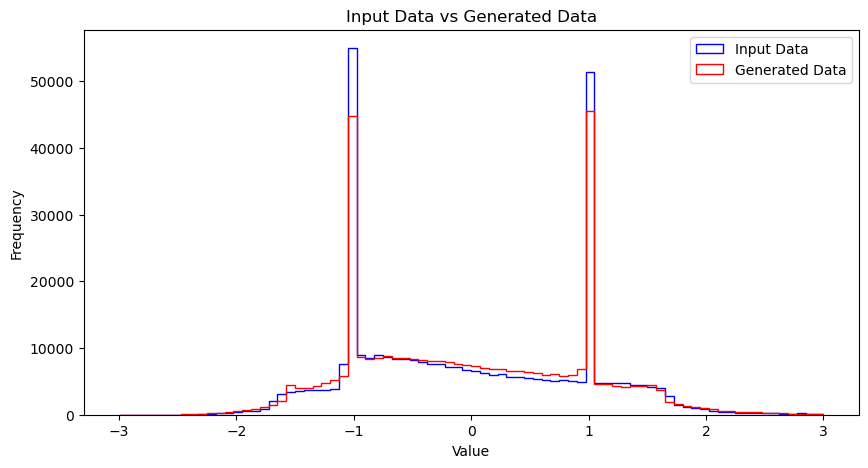

In [13]:
with torch.no_grad():
    z = torch.randn(tensor_data.size(0), best_params['z_dim']).to(device)  # Gerar amostras com o mesmo tamanho dos dados de entrada
    generated_data = model.decoder(z)

plt.figure(figsize=(10, 5))
plt.hist(tensor_data.numpy().flatten(), bins=80, range=[-3, 3], histtype='step', color='blue', label='Input Data')
plt.hist(generated_data.cpu().numpy().flatten(), bins=80, range=[-3, 3], histtype='step', color='red', label='Generated Data')
plt.title('Input Data vs Generated Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [14]:
import scipy.stats as stats
# Teste de Kolmogorov-Smirnov
train_recon_ks = stats.ks_2samp(x_train.numpy().flatten(), recon_train.numpy().flatten())
test_recon_ks = stats.ks_2samp(x_test.numpy().flatten(), recon_test.numpy().flatten())
input_generated_ks = stats.ks_2samp(tensor_data.numpy().flatten(), generated_data.numpy().flatten())

print(f"KS test for Train vs. Reconstructed Train: statistic={train_recon_ks.statistic}, p-value={train_recon_ks.pvalue}")
print(f"KS test for Test vs. Reconstructed Test: statistic={test_recon_ks.statistic}, p-value={test_recon_ks.pvalue}")
print(f"KS test for Input vs. Generated: statistic={input_generated_ks.statistic}, p-value={input_generated_ks.pvalue}")

KS test for Train vs. Reconstructed Train: statistic=0.09567204349632413, p-value=0.0
KS test for Test vs. Reconstructed Test: statistic=0.09462205364399892, p-value=4.5814370194158696e-288
KS test for Input vs. Generated: statistic=0.09087017308088308, p-value=0.0


Abaixo, iremos desnormalizar os dados para gerar plots com a distribuição original, retomando a problemática da distribuição dos momentos tranversais dos píons e dos kaons.

In [15]:
# Função para desnormalizar os dados
def denormalize(data, mean, std):
    return data * std + mean

# Desnormalizar os dados de treino, validação e teste
x_train_denorm = denormalize(x_train.cpu(), mean, std)
x_test_denorm = denormalize(x_test.cpu(), mean, std)

# Desnormalizar os dados reconstruídos e gerados
with torch.no_grad():
    # Reconstrução dos dados de treino
    recon_train, _, _ = model(x_train.to(device))
    recon_train = denormalize(recon_train.cpu(), mean, std)

    # Reconstrução dos dados de teste
    recon_test, _, _ = model(x_test.to(device))
    recon_test = denormalize(recon_test.cpu(), mean, std)

    # Geração de novos dados
    z = torch.randn(tensor_data.size(0), best_params['z_dim']).to(device)
    generated_data = model.decoder(z)
    generated_data = denormalize(generated_data.cpu(), mean, std)

# Desnormalizar os dados de entrada (linha azul)
tensor_data_denorm = denormalize(tensor_data, mean, std)

Amostra do VAE tentando reproduzir o dataset de treino (dados desnormalizados)

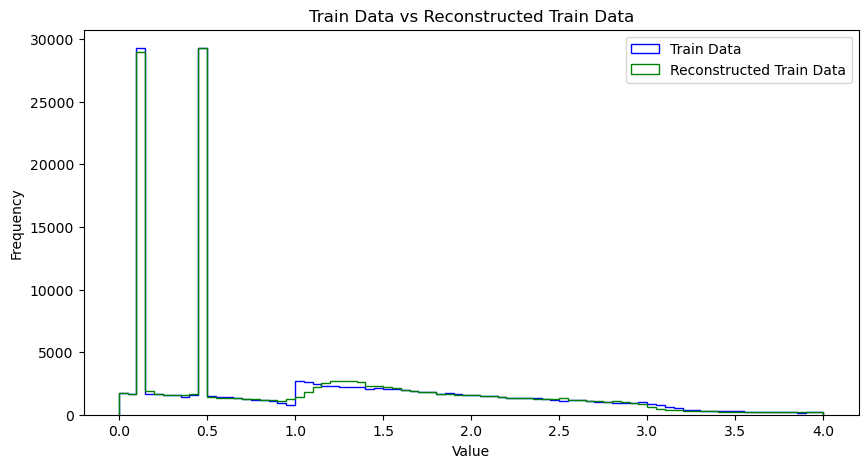

In [16]:
plt.figure(figsize=(10, 5))
plt.hist(x_train_denorm.numpy().flatten(), bins=80, range=[0, 4], histtype='step', color='blue', label='Train Data')
plt.hist(recon_train.numpy().flatten(), bins=80, range=[0, 4], histtype='step', color='green', label='Reconstructed Train Data')
plt.title('Train Data vs Reconstructed Train Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Amostra do VAE tentando reproduzir o dataset de teste (dados desnormalizados)

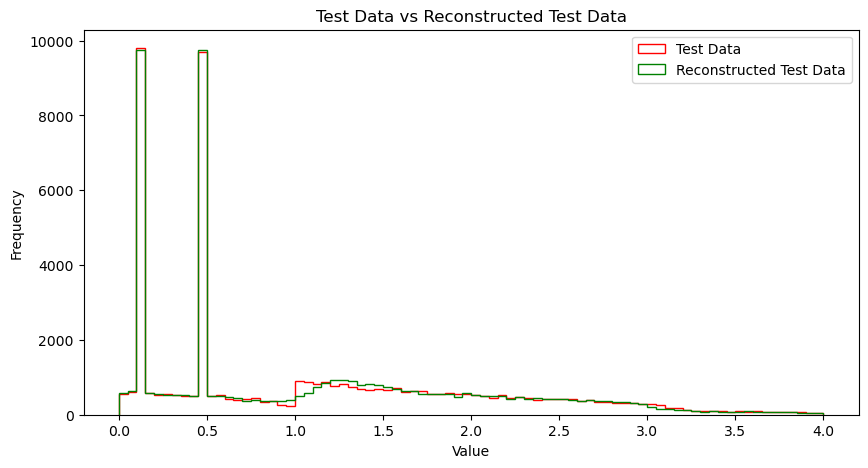

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(x_test_denorm.numpy().flatten(), bins=80, range=[0, 4], histtype='step', color='red', label='Test Data')
plt.hist(recon_test.numpy().flatten(), bins=80, range=[0, 4], histtype='step', color='green', label='Reconstructed Test Data')
plt.title('Test Data vs Reconstructed Test Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Amostra do VAE tentando gerar novos dados que seguem a mesma distribuição do input (dados desnormalizados)

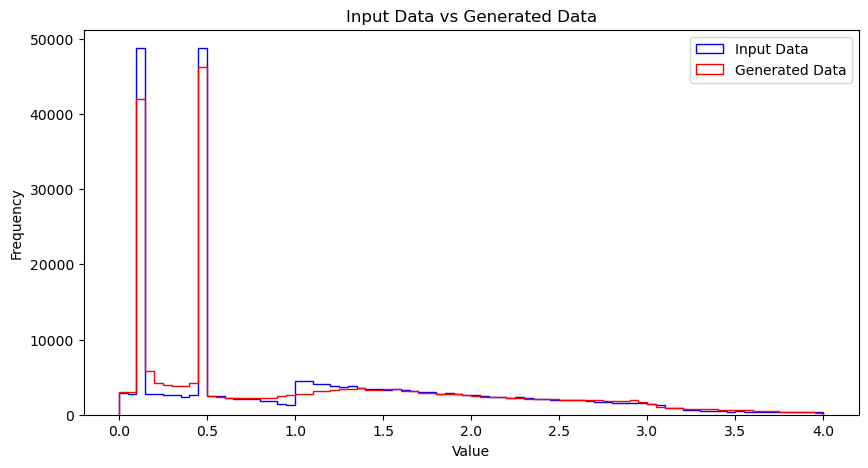

In [18]:
plt.figure(figsize=(10, 5))
plt.hist(tensor_data_denorm.numpy().flatten(), bins=80, range=[0, 4], histtype='step', color='blue', label='Input Data')
plt.hist(generated_data.numpy().flatten(), bins=80, range=[0, 4], histtype='step', color='red', label='Generated Data')
plt.title('Input Data vs Generated Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Abaixo, é rodado um teste de Kolmogorov-Smirnov para analisar a proximidade dos dois hitogramas em cada gráfico (apenas para as distribuições desnormalizadas). Uma das métricas de interesse é o p-valor.

P-Valor Significativo: um p-valor abaixo de 0.05 é frequentemente considerado significativo, o que indica que a hipótese nula (de que as distribuições são iguais) pode ser rejeitada.

P-Valor Não Significativo: Um p-valor acima de 0.05 geralmente sugere que não há evidência suficiente para rejeitar a hipótese nula. Valores como 0.10, 0.15, ou mais altos são interpretados como indicando uma falta de diferença significativa entre as distribuições.

P-Valor > 0.05: Indica que não há uma diferença significativa entre as distribuições comparadas. Esse é um bom sinal, sugerindo que as distribuições dos dados gerados ou reconstruídos são semelhantes aos dados reais.

P-Valor > 0.10 ou 0.15: Indica uma forte semelhança entre as distribuições, o que é ótimo.

In [19]:
import scipy.stats as stats
# Teste de Kolmogorov-Smirnov
train_recon_ks = stats.ks_2samp(x_train_denorm.numpy().flatten(), recon_train.numpy().flatten())
test_recon_ks = stats.ks_2samp(x_test_denorm.numpy().flatten(), recon_test.numpy().flatten())
input_generated_ks = stats.ks_2samp(tensor_data_denorm.numpy().flatten(), generated_data.numpy().flatten())

print(f"KS test for Train vs. Reconstructed Train: statistic={train_recon_ks.statistic}, p-value={train_recon_ks.pvalue}")
print(f"KS test for Test vs. Reconstructed Test: statistic={test_recon_ks.statistic}, p-value={test_recon_ks.pvalue}")
print(f"KS test for Input vs. Generated: statistic={input_generated_ks.statistic}, p-value={input_generated_ks.pvalue}")

KS test for Train vs. Reconstructed Train: statistic=0.08753906179440396, p-value=0.0
KS test for Test vs. Reconstructed Test: statistic=0.08633161744784612, p-value=8.609862049226411e-240
KS test for Input vs. Generated: statistic=0.09076450378783774, p-value=0.0
